In [ ]:
import numpy as np
import xarray as xr
import pyqg
from numpy.random import Generator, MT19937, SeedSequence
from pyqg import particles
import os
import yaml
import zarr

In [ ]:
ds = xr.open_zarr('/burg/abernathey/users/hillary/lcs/pyqg_ensemble/001.zarr', decode_times=False)
ds

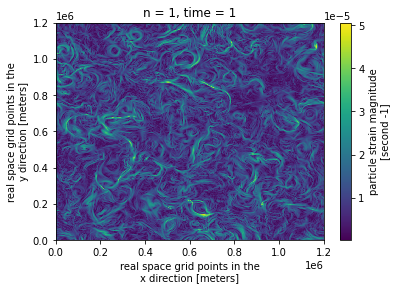

In [131]:
ds.strain[0,0].plot()

In [28]:
# ensemble member id & parameter for randomness
n = 1 #os.getenv('SLURM_ARRAY_TASK_ID') 

In [29]:
#### initial conditions from equilibrium run
pickup_file = '/burg/abernathey/users/hillary/pyqg_spin_up/84672000.nc'
ds_initial = xr.open_dataset(pickup_file)
ds_initial

<xarray.Dataset>
Dimensions:     (l: 512, k: 257, time: 1, lev: 2, lev_mid: 1, y: 512, x: 512)
Coordinates:
  * k           (k) float64 0.0 5.236e-06 1.047e-05 ... 0.00133 0.001335 0.00134
  * l           (l) float64 0.0 5.236e-06 1.047e-05 ... -1.047e-05 -5.236e-06
  * lev         (lev) int64 1 2
  * lev_mid     (lev_mid) float64 1.5
  * time        (time) timedelta64[ns] 980 days
  * x           (x) float64 1.172e+03 3.516e+03 ... 1.196e+06 1.199e+06
  * y           (y) float64 1.172e+03 3.516e+03 ... 1.196e+06 1.199e+06
Data variables: (12/16)
    APEflux     (l, k) float64 ...
    APEgen      (time) float64 ...
    APEgenspec  (l, k) float64 ...
    EKE         (lev) float64 ...
    EKEdiss     (time) float64 ...
    Ensspec     (lev, l, k) float64 ...
    ...          ...
    entspec     (l, k) float64 ...
    q           (time, lev, y, x) float64 ...
    u           (time, lev, y, x) float64 ...
    ufull       (time, lev, y, x) float64 ...
    v           (time, lev, y, x) float64 ...
    vfull       (time, lev, y, x) float64 ...
Attributes: (12/23)
    pyqg:beta:       1.3e-11
    pyqg:delta:      0.25
    pyqg:del2:       0.8
    pyqg:dt:         600.0
    pyqg:filterfac:  23.6
    pyqg:L:          1200000
    ...              ...
    pyqg:tc:         141120
    pyqg:tmax:       311040000
    pyqg:twrite:     50000
    pyqg:W:          1200000
    title:           pyqg: Python Quasigeostrophic Model
    reference:       https://pyqg.readthedocs.io/en/latest/index.html

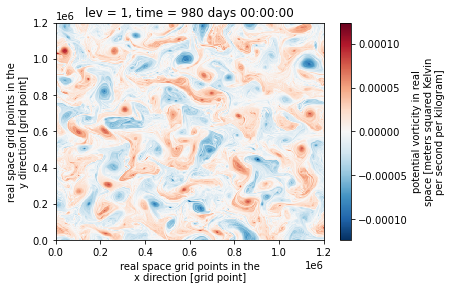

In [30]:
ds_initial.q.isel(time=0, lev=0).plot()

In [45]:
# model configuration
config_file = '/burg/home/hs3277/lcs-ml/config.yml'
with open(config_file) as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

In [91]:
### One member

# configure model
m = pyqg.QGModel(nx=config['nx'], L=config['L'], dt=config['dt'], 
                 tmax=config['tmax'], twrite=config['twrite'], 
                 tavestart=config['tavestart'], ntd=config['ntd'], 
                 beta=config['beta'], rd=config['Ld'], 
                 delta=config['delta'], H1=config['H1'], 
                 U1=config['U1'], U2=config['U2'], rek=config['rek'])

# set PV anomaly with randomness
m.set_q(ds_initial.q[0,:,:,:].values) # Add noise for ensemble

INFO:  Logger initialized


In [92]:
# Set up Lagrangian particles and advect using gridded u and v
dx = m.dx/2   # or 4
dy = m.dy/2

x0,y0 = np.meshgrid(np.arange(0,m.L,dx)+dx/2,
                    np.arange(0,m.W,dy)+dy/2)

x0 = x0.ravel()
y0 = y0.ravel()

n = -1

# Lagrangian particles with velocities given on a regular cartesian grid
lpa = particles.GriddedLagrangianParticleArray2D(x0, y0, m.nx, m.ny,
        periodic_in_x=True, periodic_in_y=True,
        xmin=0, xmax=m.L, ymin=0, ymax=m.W)

### This could be replaced by asross PR `m.add_particles(initial_coords=[x0,y0])`

uprev = m.ufull[0].copy()   
vprev = m.vfull[0].copy()

Tsave =  config['day']  # daily data is saved

In [93]:
# m.tc <= model time step
# m.dt <= Numerical timestep
# m.t <= Model time 

In [94]:
# run with snapshots, save model increments as xarray DataSet
for snapshot in m.run_with_snapshots(tsnapstart=m.t, tsnapint=m.dt):
    
    # set up velocities for Lagrangian advection
    u = m.ufull[0]
    v = m.vfull[0]

    # Advance particles using a gridded velocity field.
    lpa.step_forward_with_gridded_uv(uprev, vprev, u, v, m.dt) 

    uprev = u.copy()
    vprev = v.copy()

    if n==-1:
        qi = m.q[0].copy()
        ui = u.copy()
        vi = v.copy()

        n+=1

    # Only save daily snapshots, print numerical time step every 10 days
    if (m.t % Tsave)==0:
#         if (m.t % (Tsave*10))==0:
#             print(m.t, n)

        #### Vorticity 
        relative_vorticity = m.ifft(-(m.k**2 + m.l**2)*m.ph)[0]
        particle_vorticity = lpa.interpolate_gridded_scalar(lpa.x, lpa.y, relative_vorticity)

        ##### Strain 
        strain_normal = m.ifft(2 * m.k * m.l * m.ph)
        strain_shear = m.ifft((-m.k**2 + m.l**2)*m.ph)
        strain_magnitude = np.sqrt(strain_normal**2 + strain_shear**2)[0]
        particle_strain = lpa.interpolate_gridded_scalar(lpa.x, lpa.y, strain_magnitude)

        n+=1
    
        shape = (1, np.int64(m.L/dx), np.int64(m.W/dx))
#         ds_particles = xr.Dataset({
#             'x': (('time', 'y0', 'x0'), np.reshape(lpa.x.copy(), shape)),
#             'y': (('time', 'y0', 'x0'), np.reshape(lpa.y.copy(), shape)),
#             'vort': (('time', 'y0', 'x0'), np.reshape(particle_vorticity, shape),{'long_name': 'relative vorticity', 'units': 'second -1'}),
#             'strain': (('time', 'y0', 'x0'), np.reshape(particle_strain, shape),{'long_name': 'strain magnitude', 'units': 'second -1'}),

#             },
#             coords = {
#                 'x0': (('x0'), np.reshape(x0, shape[1:])[0,:]),
#                 'y0': (('y0'), np.reshape(y0, shape[1:])[:,0]),
#                 'time': (('time'), np.array([m.t]))            
#             }
#         )    
        ds_particles = xr.Dataset({
                'x': (('time', 'y0', 'x0'), np.reshape(lpa.x.copy(), shape),{'long_name': 'particle position in the x direction', 'units': 'meters'}),
                'y': (('time', 'y0', 'x0'), np.reshape(lpa.y.copy(), shape),{'long_name': 'particle position in the y direction', 'units': 'meters'}),
                'vort': (('time', 'y0', 'x0'), np.reshape(particle_vorticity, shape),{'long_name': 'particle relative vorticity', 'units': 'second -1'}),
                'strain': (('time', 'y0', 'x0'), np.reshape(particle_strain, shape),{'long_name': 'particle strain magnitude', 'units': 'second -1'}),
            },
                coords = {
                    'x0': (('x0'), np.reshape(x0, shape[1:])[0,:],{'long_name': 'real space grid points in the x direction', 'units': 'meters'}),
                    'y0': (('y0'), np.reshape(y0, shape[1:])[:,0],{'long_name': 'real space grid points in the y direction', 'units': 'meters'}),
                    'time': (('time'), [np.timedelta64(int(m.t),'s').astype('timedelta64[D]')],{'long_name': 'model time', 'units': 'days'})
                },
                attrs = ds_initial.attrs,
            )
            
        ds_particles = ds_particles.expand_dims(dim='n') # ensemble member
        ds_particles['n'] = [int(n)]
        ds_particles['n'].attrs = {'long_name': 'ensemble member'}
    
        
#         fn = '/burg/abernathey/users/hillary/lpa/'+ str(ds_particles.time.values[0]) +'.nc'
#         # write to same file while appending?
#         # You can add a new variable, but you cannot add data to an existing variable without re-creating it.
#         ds_particles.to_netcdf(fn, engine='h5netcdf', invalid_netcdf=True, mode='a')

        # Save as Zarr
#         fn = '/burg/abernathey/users/hillary/lpa/84672000.zarr' 
#         ds_particles = ds_particles.chunk() #this uses a global chunk
#         if m.t == Tsave:
#             ds_particles.to_zarr(fn, mode='a', consolidated=True)
#         else:
#             ds_particles.to_zarr(fn, mode='a', append_dim='time', consolidated=True)
                
    if m.t==Tsave:
        break

In [98]:
Tsave*90

7776000